<a href="https://colab.research.google.com/github/Asrst/udacity-pytorch-intro-to-neural-nets-notes/blob/master/pytorch_SmartBin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch
!pip install torchvision
!pip install pillow==5.1.0
!pip install tqdm --upgrade

Requirement already up-to-date: tqdm in /usr/local/lib/python3.6/dist-packages (4.28.1)


In [0]:
from __future__ import print_function, division
%matplotlib inline


import torch
import os
from torchvision import transforms, datasets, models

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import time
from tqdm import tqdm, trange
import copy
from torch.utils.data.sampler import SubsetRandomSampler
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [0]:
data_transforms = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [4]:
!unzip -q dataset.zip

replace dataset-resized/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: [y]
error:  invalid response [[y]]
replace dataset-resized/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: [A]
error:  invalid response [[A]]
replace dataset-resized/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [0]:
data_dir = 'dataset-resized'
image_dataset = datasets.ImageFolder(data_dir, data_transforms)

In [0]:
train_size = int(0.9 * len(image_dataset))
val_size = len(image_dataset) - train_size

In [0]:
train_dataset, valid_dataset = torch.utils.data.random_split(image_dataset, [train_size, val_size])

In [0]:
dataloaders = {}
dataloaders['train'] = torch.utils.data.DataLoader(train_dataset, batch_size = 24, shuffle=True) 
dataloaders['valid'] = torch.utils.data.DataLoader(valid_dataset, batch_size = 24, shuffle=False)

In [10]:
class_names = image_dataset.classes
class_names

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

In [0]:
dataset_sizes = {'train': len(train_dataset), 'valid' : len(valid_dataset)}

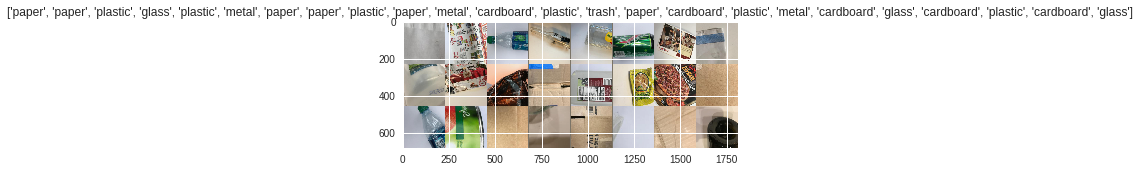

In [12]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_acc = 0.0

    for epoch in trange(num_epochs):
        print('\nEpoch {}/{}'.format(epoch, num_epochs - 1))

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
        print('-' * 10)

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [0]:
model_ft = models.resnet152(pretrained = True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 6)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [22]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs = 10)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0/9
train Loss: 1.0713 Acc: 0.5994



 10%|█         | 1/10 [02:52<25:54, 172.70s/it]

valid Loss: 0.5997 Acc: 0.7984
----------
Epoch 1/9
train Loss: 0.5188 Acc: 0.8241



 20%|██        | 2/10 [05:45<23:01, 172.71s/it]

valid Loss: 0.3616 Acc: 0.8577
----------
Epoch 2/9
train Loss: 0.3628 Acc: 0.8813



 30%|███       | 3/10 [08:38<20:09, 172.81s/it]

valid Loss: 0.3525 Acc: 0.8775
----------
Epoch 3/9
train Loss: 0.2910 Acc: 0.8984



 40%|████      | 4/10 [11:31<17:17, 172.87s/it]

valid Loss: 0.2965 Acc: 0.9130
----------
Epoch 4/9
train Loss: 0.2404 Acc: 0.9138



 50%|█████     | 5/10 [14:24<14:24, 172.81s/it]

valid Loss: 0.2943 Acc: 0.9012
----------
Epoch 5/9
train Loss: 0.2286 Acc: 0.9182



 60%|██████    | 6/10 [17:17<11:31, 172.84s/it]

valid Loss: 0.2862 Acc: 0.9012
----------
Epoch 6/9
train Loss: 0.1910 Acc: 0.9354



 70%|███████   | 7/10 [20:10<08:38, 172.90s/it]

valid Loss: 0.3335 Acc: 0.9012
----------
Epoch 7/9
train Loss: 0.1687 Acc: 0.9459



 80%|████████  | 8/10 [23:02<05:45, 172.86s/it]

valid Loss: 0.2492 Acc: 0.9130
----------
Epoch 8/9
train Loss: 0.1730 Acc: 0.9393



 90%|█████████ | 9/10 [25:55<02:52, 172.79s/it]

valid Loss: 0.2332 Acc: 0.9130
----------
Epoch 9/9
train Loss: 0.1517 Acc: 0.9494



100%|██████████| 10/10 [28:48<00:00, 172.80s/it]


valid Loss: 0.2452 Acc: 0.9170
----------
Training complete in 28m 48s
Best val Acc: 0.916996


In [0]:
torch.save(model_ft.state_dict(), 'smartbin_rs152.pth')

In [0]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['valid']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

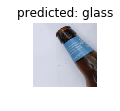

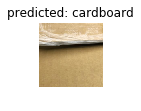

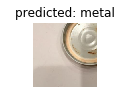

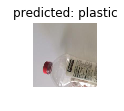

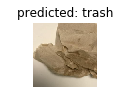

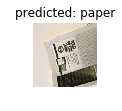

In [0]:
visualize_model(model_ft)

plt.ioff()
plt.show()